### Considered model: four-bar linkage (= two link manipulator + one link manipulator + rigid coupling)


This Notebook depends on symbtools >=0.2.5

→ `pip install --upgrade symbtools`





In [1]:
%load_ext ipydex.displaytools
%matplotlib inline

import sys
# to load assimulo under wsl2
sys.path.append('/home/kwrede/miniconda3/lib/python3.8/site-packages')
sys.path.append('/home/wredi/miniconda3/lib/python3.8/site-packages')

import os
import pickle
import sympy as sp
import numpy as npy  # we need `np` later 
from sympy import sin, cos, pi
from sympy.interactive import printing

# using wredsen's symbtools fork (https://github.com/wredsen/symbtools @ DAE_statefeedback), assuming repos SA-Wrede and symbtools share the same parent directory
sys.path.append('../../symbtools/')
import symbtools as st
import symbtools.modeltools as mt
from symbtools.modeltools import Rz # Rotationsmatrix in the xy plane (c, -s; s, c)

import scipy.integrate as sc_integrate
from scipy.optimize import fmin
import matplotlib.pyplot as pl
from assimulo.solvers import ODASSL as SOLVER # Imports the solver ODASSL from Assimulo
from assimulo.problem import Overdetermined_Problem # Imports the problem formulation from Assimulo
import ipydex
plt = pl

printing.init_printing(1)

Could not find No module named 'assimulo.solvers.sundials'
Could not find No module named 'assimulo.solvers.kinsol'
/home/wredi/.local/lib/python3.8/site-packages/assimulo/solvers/odepack.py:701: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  N.array([[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.],  # 5th order
Could not find GLIMDA.


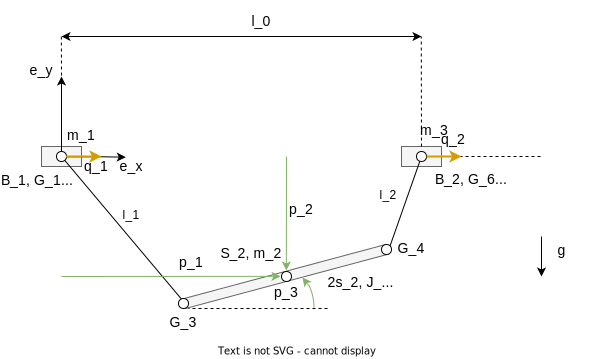

In [2]:
from IPython.display import Image
from IPython.core.display import SVG
SVG(filename='ODE_flatness_analysis_simulation_diagram.svg')

In [3]:
t = sp.Symbol('t')  # time variable

# coordinates
np = 3 # number of passive coordinates (not directly actuated)
nq = 2 # number of actuated coordinates
n = np + nq

pp = st.symb_vector("p1:{0}".format(np+1)) # vector of passive coordinates
qq = st.symb_vector("q1:{0}".format(nq+1)) # vector of actuated coordinates



# vector of control inputs
aa = st.symb_vector("a1:{0}".format(4+1)) ##:T
# vector of all coordinates
ttheta = st.row_stack(pp, qq) ##:T
# vector of velocities 
tthetad = st.time_deriv(ttheta, ttheta) ##:T
# vector of accelerations
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T
tthetaddd = st.time_deriv(ttheta, ttheta, order=3) ##:T
tthetadddd = st.time_deriv(ttheta, ttheta, order=4) ##:T

st.make_global(ttheta, tthetad, tthetadd, tthetaddd, tthetadddd)

QQ = st.symb_vector("Q1:{0}".format(n+1)) ##:T # vector of generalized foces
st.make_global(QQ)

---

---

---

---

---

---

---

In [4]:
# symbols for analytic equations
params = sp.symbols('s2, m1, m2, m3, J1, J2, J3, mc1b, mc2b d1, d4, l0, l1, l2, l3, g')
st.make_global(params)

# symbols for control inputs
# ttau = sp.symbols('tau')
tau1, tau2, tau3, tau4 = ttau = st.symb_vector("tau1, tau2, tau3, tau4")


Specify the geometry (joints G and centers of masses S)

---

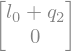

---

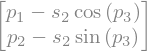

---

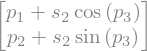

---

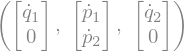

---

In [5]:
# unit vectors
ex = sp.Matrix([1, 0])
ey = sp.Matrix([0, 1])

# basis 1 and 2 (cart positions)
S1 = G1 = B1 = sp.Matrix([q1, 0]) ##:
S3 = G6 = B2 = sp.Matrix([l0 + q2, 0]) ##:

# center of gravity of load
S2 = sp.Matrix([p1, p2])

# suspension points of load
G3 = S2 - Rz(p3)*ex*s2 ##:
G4 = S2 + Rz(p3)*ex*s2 ##:

# Time derivatives of centers of masses
Sd1, Sd2, Sd3 = st.col_split(st.time_deriv(st.col_stack(S1, S2, S3), ttheta)) ##:

this model is very easy ...

---

---

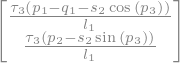

---

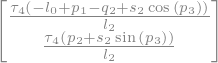

---

In [6]:
F1 = sp.Matrix([tau1, 0])  ##:T
F2 = sp.Matrix([tau2, 0])  ##:T

# unit vectors for ropes to split forces according to angles
rope1 = (G3 - S1)
rope2 = (G4 - S3)
uv_rope1 = rope1/sp.sqrt((rope1.T*rope1)[0])
uv_rope2 = rope2/sp.sqrt((rope2.T*rope2)[0])

# simplify expressions by using l1, l2 as shortcuts 
uv_rope1 = rope1/l1
uv_rope2 = rope2/l2

F3 = uv_rope1 * tau3 ##:
F4 = uv_rope2 * tau4 ##:

#### Quasistatic state feedback control

In [78]:
# load model etc. from pickle of flatness analysis notebook
with open("flatness_analysis_control.pcl", "rb") as pfile:
    data = pickle.load(pfile)
    locals().update(data)

Nonlinearities are chosen to be the new inputs of the system:
\begin{align}
    v_1 &:= \ddot{p}_1 = \ddot{y}_1 \\
    v_2 &:= \ddddot{p}_2 = \ddddot{y}_2 \\
    v_3 &:= \ddot{p}_3 = \ddot{y}_3 \\
    v_4 &:= \ddot{q}_1 = \ddot{y}_4 
\end{align}

In [113]:
vv = st.symb_vector("v1:{0}".format(4+1)) # vector of new inputs
vvd = st.time_deriv(vv, vv)
vvdd = st.time_deriv(vv, vv, order=2)

st.make_global(vv, vvd, vvdd)

In [114]:
ttaud = st.time_deriv(ttau, ttau)
ttaudd = st.time_deriv(ttau, ttau, order=2)

st.make_global(ttaud, ttaudd)

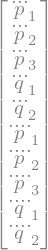

---

In [115]:
xxdot = st.time_deriv(mod.xx, mod.xx, order=1)
xxddot = st.time_deriv(mod.xx, mod.xx, order=2)
xxdddot = st.time_deriv(mod.xx, mod.xx, order=3) ##:

In [116]:
xx_ext = sp.Matrix(2*len(mod.xx) + 2*len(mod.tau) + 2*len(vv), 1, [*mod.xx, *xxddot, *ttau, *ttaud, *vv, *vvd])
fg_ext = sp.Matrix(2*len(mod.state_eq) + 2*len(mod.tau) + 2*len(vv), 1, [*mod.state_eq, *xxdddot, *ttaud, *ttaudd, *vvd, *vvdd])

In [117]:
y1_ext = xx_ext[0]
ydot1_ext = st.lie_deriv(y1_ext, fg_ext, xx_ext)
yddot1_ext = st.lie_deriv(ydot1_ext, fg_ext, xx_ext)
ydddot1_ext = st.lie_deriv(yddot1_ext, fg_ext, xx_ext)
yddddot1_ext = st.lie_deriv(ydddot1_ext, fg_ext, xx_ext)

ydot1_ext.s ##:
yddot1_ext.s ##:
ydddot1_ext.s ##:
yddddot1_ext.s ##:

---

---

---

---

In [118]:
y2_ext = xx_ext[1]
ydot2_ext = st.lie_deriv(y2_ext, fg_ext, xx_ext)
yddot2_ext = st.lie_deriv(ydot2_ext, fg_ext, xx_ext)
ydddot2_ext = st.lie_deriv(yddot2_ext, fg_ext, xx_ext)
yddddot2_ext = st.lie_deriv(ydddot2_ext, fg_ext, xx_ext)

ydot2_ext.s ##:
yddot2_ext.s ##:
ydddot2_ext.s ##:
yddddot2_ext.s ##:

---

---

---

---

In [119]:
y3_ext = xx_ext[2]
ydot3_ext = st.lie_deriv(y3_ext, fg_ext, xx_ext)
yddot3_ext = st.lie_deriv(ydot3_ext, fg_ext, xx_ext)
ydddot3_ext = st.lie_deriv(yddot3_ext, fg_ext, xx_ext)
yddddot3_ext = st.lie_deriv(ydddot3_ext, fg_ext, xx_ext)

ydot3_ext.s ##:
yddot3_ext.s ##:
ydddot3_ext.s ##:
yddddot3_ext.s ##:

---

---

---

---

In [120]:
y4_ext = xx_ext[3]
ydot4_ext = st.lie_deriv(y4_ext, fg_ext, xx_ext)
yddot4_ext = st.lie_deriv(ydot4_ext, fg_ext, xx_ext)
ydddot4_ext = st.lie_deriv(yddot4_ext, fg_ext, xx_ext)
yddddot4_ext = st.lie_deriv(ydddot4_ext, fg_ext, xx_ext)

ydot4_ext.s ##:
yddot4_ext.s ##:
ydddot4_ext.s ##:
yddddot4_ext.s ##:

---

---

---

---

In [121]:
# v_j = m_i * tau_i + n_i

In [122]:
m1 = yddot4_ext.diff(tau1)
n1 = yddot4_ext.subs(tau1, 0)
qstat_tau1 = (vv[3] - n1)/ m1
qstat_tau1.s ##:
qstat_tau1.co ##:

---

---

In [123]:
m2 = yddddot2_ext.diff(tau2)
n2 = yddddot2_ext.subs(tau2, 0)
qstat_tau2 = (vv[1] - n2)/ m2
qstat_tau2.s ##:
qstat_tau2.co ##:

---

---

In [124]:
m3 = yddot1_ext.diff(tau3)
n3 = yddot1_ext.subs(tau3, 0)
qstat_tau3 = (vv[0] - n3)/ m3
qstat_tau3.s ##:
qstat_tau3.co ##:

---

---

In [125]:
m4 = yddot3_ext.diff(tau4)
n4 = yddot3_ext.subs(tau4, 0)
qstat_tau4 = (vv[2] - n4)/ m4
qstat_tau4.s ##:
qstat_tau4.co ##:

---

---

In [126]:
sol_tau134 = sp.solve((tau1-qstat_tau1, tau3-qstat_tau3, tau4-qstat_tau4), tau1, tau3, tau4)

In [127]:
qstat_tau1 = sol_tau134[tau1].smplf
qstat_tau3 = sol_tau134[tau3].smplf
qstat_tau4 = sol_tau134[tau4].smplf

In [128]:
qstat_tau1.s ##:
qstat_tau1.co ##:
qstat_tau3.s ##:
qstat_tau3.co ##:
qstat_tau4.s ##:
qstat_tau4.co ##:

---

---

---

---

---

---

In [129]:
qstat_tau3_dot = st.lie_deriv(qstat_tau3, fg_ext, xx_ext)
qstat_tau3_dot.s ##:
qstat_tau3_dot.co ##:
qstat_tau3_ddot = st.lie_deriv(qstat_tau3_dot, fg_ext, xx_ext)
qstat_tau3_ddot.s ##:
qstat_tau3_ddot.co ##:

qstat_tau4_dot = st.lie_deriv(qstat_tau4, fg_ext, xx_ext)
qstat_tau4_dot.s ##:
qstat_tau4_dot.co ##:
qstat_tau4_ddot = st.lie_deriv(qstat_tau4_dot, fg_ext, xx_ext)
qstat_tau4_ddot.s ##:
qstat_tau4_ddot.co ##:

---

---

---

---

---

---

---

---

In [130]:
qstat_tau2 = qstat_tau2.subz([ttaudd[2], ttaudd[3], ttaud[2], ttaud[3], ttau[0], ttau[2], ttau[3]], 
                             [qstat_tau3_ddot, qstat_tau4_ddot, qstat_tau3_dot, qstat_tau4_dot, qstat_tau1, qstat_tau3, qstat_tau4])

In [131]:
qstat_tau2.s ##:
qstat_tau2.co ##:

---

---

In [132]:
mc2 = qstat_tau2.diff(tau2)
nc2 = qstat_tau2.subs(tau2, 0)

In [133]:
qstat_tau2 = 1/(1-mc2) * nc2
qstat_tau2.s ##:
qstat_tau2.co ##:

---

---

#### State feedback for control

In [134]:
# define symbols for measured states
p_meas = st.symb_vector("pm1:{0}".format(3+1)) # error vector of passive coordinates
q_meas = st.symb_vector("qm1:{0}".format(2+1)) # error vector of actuated coordinates

meas_states = st.row_stack(p_meas, q_meas)
meas_states_d = st.time_deriv(meas_states, meas_states)
meas_states_dd = st.time_deriv(meas_states, meas_states, order=2)
meas_states_ddd = st.time_deriv(meas_states, meas_states, order=3)
meas_states_dddd = st.time_deriv(meas_states, meas_states, order=4)

st.make_global(meas_states, meas_states_d, meas_states_dd, meas_states_ddd, meas_states_dddd)

# define symbols for reference trajectory states
p_ref = st.symb_vector("pr1:{0}".format(3+1)) # error vector of passive coordinates
q_ref = st.symb_vector("qr1:{0}".format(2+1)) # error vector of actuated coordinates

ref_states = st.row_stack(p_ref, q_ref)
ref_states_d = st.time_deriv(ref_states, ref_states)
ref_states_dd = st.time_deriv(ref_states, ref_states, order=2)
ref_states_ddd = st.time_deriv(ref_states, ref_states, order=3)
ref_states_dddd = st.time_deriv(ref_states, ref_states, order=4)

st.make_global(ref_states, ref_states_d, ref_states_dd, ref_states_ddd, ref_states_dddd)

#### Linear feedback error:
$$
e := y - y_{\text{ref}}
$$

#### Error dynamics:
$$
e^{(n)} + c_{n-1} e^{(n-1)} + ... + c_{1} \dot{e} + c_{0} e = 0 
\Leftrightarrow y^{(n)} = y_{\text{ref}}^{(n)} - c_{n-1} e^{(n-1)} - ... - c_{1} \dot{e} - c_{0} e
$$

In [136]:
v1_expr = prddot1 #+ 2*(prdot1 - pdot1) + (pr1 - p1)  
v3_expr = prddot3 #+ 2*(prdot3 - pdot3) + (pr3 - p3)
v4_expr = qrddot1 #+ 2*(qrdot1 - qdot1) + (qr1 - q1)

In [137]:
v2_expr = prddddot2 + 4*(prdddot2 - pdddot2) + 6*(prddot2 - pddot2) + 4*(prdot2 - pdot2) + 1 ##:

---

##### Quasi static state feedback for $\dot{v}_1$, $\ddot{v}_1$, $\dot{v}_3$, $\ddot{v}_3$:
\begin{align}
    \ddot{e} + c_1 \dot{e} + c_0 e &= 0 \\
    e^{(3)} + c_1 \ddot{e} + c_0 \dot{e} &= 0 \\
    e^{(3)} + c_1 (-c_1 \dot{e} - c_0 e) + c_0 dot{e} &= 0 \\
    e^{(3)} - c_1^2 \dot{e} + c_0 \dot{e} - c_0 c_1 e &= 0 \\
    e^{(3)} + (c_0 - c_1^2) \dot{e} - c_0 c_1 e &= 0 \\
    e^{(4)} + (c_0 - c_1^2) \ddot{e} - c_0 c_1 \dot{e} &= 0 \\
    e^{(4)} + (c_0 - c_1^2) (-c_1 \dot{e} - c_0 e) - c_0 c_1 \dot{e} &= 0 \\
    e^{(4)} + (c_1^2 - 2 c_0 c_1) \dot{e} + (c_0 c_1^2 - c_0^2) e &= 0 \\
    \Rightarrow y^{(3)} &= y_{\text{ref}}^{(3)} - (c_0 - c_1^2) \dot{e} + c_0 c_1 e \\
    \Rightarrow y^{(4)} &= y_{\text{ref}}^{(4)} - (c_1^3 - 2 c_0 c_1) \dot{e} - (c_0 c_1^2 - c_0^2) e
\end{align}

In [138]:
# vdot1 = y1^(3)
vdot1_expr = prdddot1 + 3*(prdot1 - pdot1) + 2*(pr1 - p1)
# vddot1 = y1^(4)
vddot1_expr = prddddot1 - 4*(prdot1 - pdot1) - 3*(pr1 - p1)

# vdot3 = y3^(3)
vdot3_expr = prdddot3 + 3*(prdot3 - pdot3) + 2*(pr3 - p3)
# vddot3 = y3^(4)
vddot3_expr = prddddot3 - 4*(prdot3 - pdot3) - 3*(pr3 - p3)

In [139]:
pddot2_expr = mod.f[-4] + (mod.g[-4, :] * ttau)[0]
pddot2_expr = pddot2_expr.subz([tau3, tau4, v1, v3], [qstat_tau3, qstat_tau4, v1_expr, v3_expr])
pddot2_expr.s

In [140]:
pdddot2_expr = st.lie_deriv(pddot2_expr, fg_ext, xx_ext)
pdddot2_expr = pdddot2_expr.subz([tau3, tau4, v1, v3], [qstat_tau3, qstat_tau4, v1_expr, v3_expr])
pdddot2_expr.s

In [141]:
v2_expr = v2_expr.subz([pddot2, pdddot2], [pddot2_expr, pdddot2_expr])
v2_expr.s

In [142]:
### substitute new inputs into tau

In [143]:
qstat_tau1 = qstat_tau1.subz([v1, v3, v4], [v1_expr, v3_expr, v4_expr])
qstat_tau1 = qstat_tau1.subz([*tthetadd, *tthetad, *ttheta], [*ref_states_dd, *ref_states_d, *ref_states])
qstat_tau1.s ##:
qstat_tau1.co ##:

---

---

In [144]:
qstat_tau3 = qstat_tau3.subz([v1, v3], [v1_expr, v3_expr])
qstat_tau3 = qstat_tau3.subz([*tthetadd, *tthetad, *ttheta], [*ref_states_dd, *ref_states_d, *ref_states])
qstat_tau3.s ##:
qstat_tau3.co ##:

---

---

In [145]:
qstat_tau4 = qstat_tau4.subz([v1, v3], [v1_expr, v3_expr])
qstat_tau4 = qstat_tau4.subz([*tthetadd, *tthetad, *ttheta], [*ref_states_dd, *ref_states_d, *ref_states])
qstat_tau4.s ##:
qstat_tau4.co ##:

---

---

In [76]:
qstat_tau2 = qstat_tau2.subz([v1, v2, v3, v4, vdot1, vdot3, vddot1, vddot3], 
                             [v1_expr, v2_expr, v3_expr, v4_expr, vdot1_expr, vdot3_expr, vddot1_expr, vddot3_expr])
qstat_tau2 = qstat_tau2.subz([*tthetadd, *tthetad, *ttheta], [*meas_states_dd, *meas_states_d, *meas_states])
qstat_tau2.s ##:
qstat_tau2.co ##:

---

---

In [146]:
# store with pickle
pickle_data = {"qstat_tau1":qstat_tau1, "qstat_tau2":qstat_tau2, "qstat_tau3":qstat_tau3, "qstat_tau4":qstat_tau4}

with open("qstat_expr.pcl", "wb") as pfile:
    pickle.dump(pickle_data, pfile)

In [71]:
# coefficients for error dynamics
# Polynome: s^2 + c_i[1] s + c_i[0] s
cp1 = [1, 2]
cp2 = [1, 2]
cp3 = [1, 2]
cq1 = [1, 2]
c2 = sp.Matrix([cp1, cp2, cp3, cq1, [0, 0]])

Every component of the flat output $\mathbf{y}$ appearing in $\mathbf{\tau}$ with a higher order derivative than 1 has to be substituted, becaus it is assumed that only positions and speeds of $\mathbf{y}$ can be measured directly.

##### State feedback error dynamics:
\begin{align}
    \ddot{e} + c_1 \dot{e} + c_0 e &= 0 \\
\end{align}

In [72]:
from sympy.matrices.dense import matrix_multiply_elementwise as elmul

In [73]:
c2_00 = elmul(c2[:, 0], c2[:, 0])
c2_01 = elmul(c2[:, 0], c2[:, 1])
c2_11 = elmul(c2[:, 1], c2[:, 1])
c2_111 = elmul(elmul(c2[:, 1], c2[:, 1]), c2[:, 1])
c2_011 = elmul(elmul(c2[:, 0], c2[:, 1]), c2[:, 1])

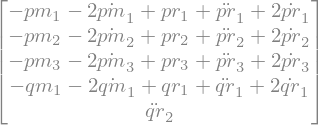

---

In [74]:
meas_subs_dd = ref_states_dd - elmul(c2[:, 1], (meas_states_d - ref_states_d)) - elmul(c2[:, 0], (meas_states - ref_states)) ##:

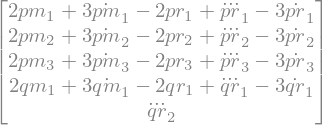

---

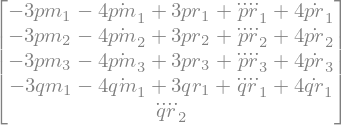

---

In [75]:
# for quasi static state feedback approach
meas_subs_ddd = ref_states_ddd - elmul((c2[:, 0] - c2_11), (meas_states_d - ref_states_d)) + elmul(c2_01, (meas_states - ref_states)) ##:
meas_subs_dddd = ref_states_dddd - elmul((c2_111 - 2*c2_01), (meas_states_d - ref_states_d)) - elmul((c2_011 - c2_00), (meas_states - ref_states)) ##:

#### Inputs from flat output

In [50]:
flat_tau2.co

In [51]:
yddddot2_ext.s

In [35]:
sol_tau134 = sp.solve((pddot1-yddot1_ext, pddot3-yddot3_ext, qddot1-yddot4_ext), tau1, tau3, tau4)

In [36]:
tau1_alg = sol_tau134[tau1].smplf
tau3_alg = sol_tau134[tau3].smplf
tau4_alg = sol_tau134[tau4].smplf

In [37]:
tau1_alg.co ##:
tau3_alg.co ##:
tau4_alg.co ##:

---

---

---

In [25]:
tau1_alg_flat = tau1_alg.subs(q2, flat_q2)
tau3_alg_flat = tau3_alg.subs(q2, flat_q2)
tau4_alg_flat = tau4_alg.subs(q2, flat_q2)

In [26]:
tau1_alg_flat = tau1_alg_flat.subz([*tthetadd, *tthetad, *ttheta], [*meas_subs_dd, *meas_states_d, *meas_states])
tau1_alg_flat = tau1_alg_flat.subz([*ref_states_dd, *ref_states_d, *ref_states], [*tthetadd, *tthetad, *ttheta])
tau3_alg_flat = tau3_alg_flat.subz([*tthetadd, *tthetad, *ttheta], [*meas_subs_dd, *meas_states_d, *meas_states])
tau3_alg_flat = tau3_alg_flat.subz([*ref_states_dd, *ref_states_d, *ref_states], [*tthetadd, *tthetad, *ttheta])
tau4_alg_flat = tau4_alg_flat.subz([*tthetadd, *tthetad, *ttheta], [*meas_subs_dd, *meas_states_d, *meas_states])
tau4_alg_flat = tau4_alg_flat.subz([*ref_states_dd, *ref_states_d, *ref_states], [*tthetadd, *tthetad, *ttheta])

In [27]:
tau1_alg_flat.s ##:
tau3_alg_flat.s ##:
tau4_alg_flat.s ##:

---

---

---

In [28]:
taudot3_alg = st.lie_deriv(tau3_alg, fg_ext, xx_ext, order=1)
tauddot3_alg = st.lie_deriv(taudot3_alg, fg_ext, xx_ext, order=1)
taudot4_alg = st.lie_deriv(tau4_alg, fg_ext, xx_ext, order=1)
tauddot4_alg = st.lie_deriv(taudot4_alg, fg_ext, xx_ext, order=1)

In [29]:
flat_tau2.s

In [30]:
flat_q2.s

In [31]:
flat_qddot2 = st.lie_deriv(flat_q2, fg_ext, xx_ext, order=2)
flat_qddot2.s

In [32]:
flat_qddot2.co

flat_qddot2 is already to large and would also need a substitution of the control forces $\tau_1, \tau_3, \tau_4$ to then be used in a representation of $\tau_2$

In [33]:
# store with pickle
pickle_data = {"tau1_alg":tau1_alg, "tau3_alg":tau3_alg, "tau4_alg":tau4_alg}

with open("symb_expr.pcl", "wb") as pfile:
    pickle.dump(pickle_data, pfile)